# Clustering Mega Notebook

**Clustering**
* Unsupervised machine learning algorithm

*Hard Clustering*
* Partitioning of data points into groups of similar objects
    * Each point belongs to one and only one cluster (class)
    * Given the class, it should give you info about the members

*Soft Clustering*
* Each point belongs to all clusters with certain affinity
* e.g. Gaussian mixture model


Clustering reserves no guarantee that the resulting clusters will have specific characteristics.

In [161]:
import inspect

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors

from sklearn.datasets import (
    make_blobs,
    make_moons,
    make_circles
)

from sklearn.cluster import (
    KMeans,
    DBSCAN,
    OPTICS,
    cluster_optics_dbscan,
    AgglomerativeClustering,
)

from sklearn.metrics import (
    pairwise_distances,
    calinski_harabasz_score,
    silhouette_score,
    silhouette_samples,
    davies_bouldin_score,
)

from scipy.cluster.hierarchy import (
    dendrogram,
    linkage,
    fcluster
)

In [162]:
random_state = 33

## Representative-Based Clustering
1. Identify a representative of a cluster
2. Assign a data point to its closest representative using the distance / similarity function
3. From the resulting clusters, choose a new representative that minimizes the objective function (sum of distances between a point to its cluster representative)
4. Repeat step 2-3 until convergence -> after an iteration, there's no change in the members of the cluster / no change in the set of representatives

*How you determine the representative of a cluster will indicate what type of representative-based clustering algorithm you are using.*

### $k$-means Clustering
* distance function = L2 norm = Euclidean distance
* representative is chosen to be the mean of the points in the cluster
    * mean minimizes the distance between the cluster of points

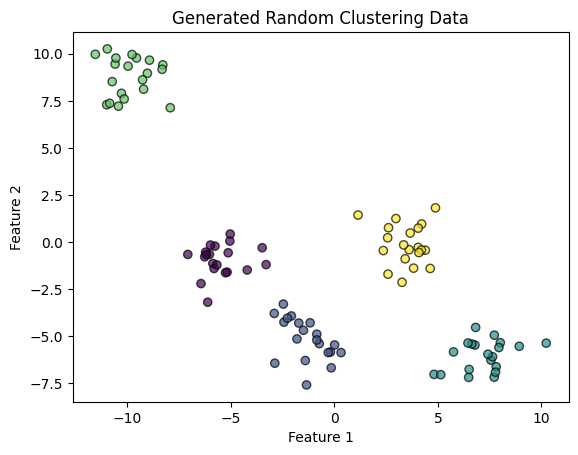

In [163]:
X, y = make_blobs(
    n_samples=100,
    centers=5,
    random_state=random_state
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.7, edgecolors='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Generated Random Clustering Data")
plt.show()

In [164]:
help(KMeans)

Help on class KMeans in module sklearn.cluster._kmeans:

class KMeans(_BaseKMeans)
 |  KMeans(n_clusters=8, *, init='k-means++', n_init='auto', max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='lloyd')
 |  
 |  K-Means clustering.
 |  
 |  Read more in the :ref:`User Guide <k_means>`.
 |  
 |  Parameters
 |  ----------
 |  
 |  n_clusters : int, default=8
 |      The number of clusters to form as well as the number of
 |      centroids to generate.
 |  
 |      For an example of how to choose an optimal value for `n_clusters` refer to
 |      :ref:`sphx_glr_auto_examples_cluster_plot_kmeans_silhouette_analysis.py`.
 |  
 |  init : {'k-means++', 'random'}, callable or array-like of shape             (n_clusters, n_features), default='k-means++'
 |      Method for initialization:
 |  
 |      * 'k-means++' : selects initial cluster centroids using sampling             based on an empirical probability distribution of the points'             contribution to t

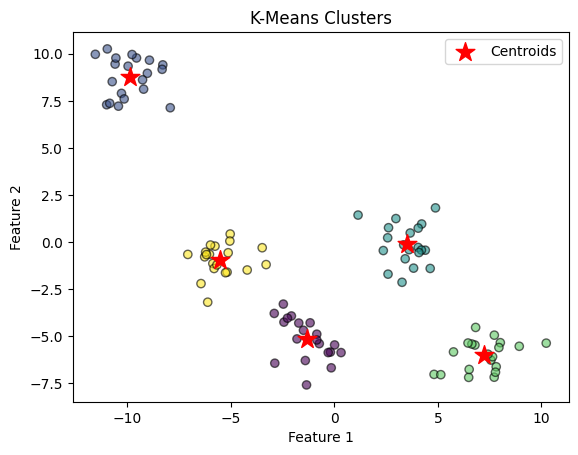

In [165]:
kmeans = KMeans(n_clusters=5, random_state=random_state, n_init="auto")
y_pred = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_

plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap="viridis", alpha=0.6, edgecolors="k")
plt.scatter(centroids[:, 0], centroids[:, 1], c="red", marker='*', s=200, label="Centroids")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.title("K-Means Clusters")
plt.show()

## Cluster Validation
1. Compact
2. Separated
3. Balanced
4. Parsimonious

### Internal Validation Criteria
* each clustering method will have an appropriate criterion, some can be biased towards a family of clustering algorithms

#### (1) Sum of squares distances to centroids
* the sum of squares distances to the representative points
* optimized for distance-based algorithms
* minimum is 0, the smaller the better

In [6]:
def dist(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))


def pooled_within_ssd(X, y, centroids, dist):
    """Compute pooled within-cluster sum of squares around the cluster mean

    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    centroids : array
        Cluster centroids
    dist : callable
        Distance between two points. It should accept two arrays, each
        corresponding to the coordinates of each point

    Returns
    -------
    float
        Pooled within-cluster sum of squares around the cluster mean
    """

    sum_squares = []
    for i, centroid in enumerate(centroids): # loop through each centroid
        X_filtered = X[y == i] # get data points within cluster i
        X_distances = [dist(X_point, centroid) ** 2  for X_point in X_filtered] # squared distance from centroid
        X_pooled = [1/(2*len(X_filtered)) * X_distance for X_distance in X_distances]  # normalize
        sum_squares.append(np.sum(X_pooled))
        
    return np.sum(sum_squares)

In [7]:
pooled_within_ssd_metric = pooled_within_ssd(X, y, centroids, dist)

print(f"Pooled within SSD is: {pooled_within_ssd_metric:.2f}")

Pooled within SSD is: 231.50


#### (2) Calinski-Harabasz Index
* the ratio of the between-clusters dispersion mean and the within-cluster dispersion
* the higher the value, the more defined the clusters are
* bounded 0 to infinity

$$s_k = \frac{B_k/(k-1)}{W_k/(n-k)}$$

In [8]:
help(calinski_harabasz_score)

Help on function calinski_harabasz_score in module sklearn.metrics.cluster._unsupervised:

calinski_harabasz_score(X, labels)
    Compute the Calinski and Harabasz score.
    
    It is also known as the Variance Ratio Criterion.
    
    The score is defined as ratio of the sum of between-cluster dispersion and
    of within-cluster dispersion.
    
    Read more in the :ref:`User Guide <calinski_harabasz_index>`.
    
    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        A list of ``n_features``-dimensional data points. Each row corresponds
        to a single data point.
    
    labels : array-like of shape (n_samples,)
        Predicted labels for each sample.
    
    Returns
    -------
    score : float
        The resulting Calinski-Harabasz score.
    
    References
    ----------
    .. [1] `T. Calinski and J. Harabasz, 1974. "A dendrite method for cluster
       analysis". Communications in Statistics
       <https://www.tandfonline.com/

In [9]:
ch_score = calinski_harabasz_score(X, y_pred)

print(f"Calinski-Harabasz Score is: {ch_score:.2f}")

Calinski-Harabasz Score is: 799.75


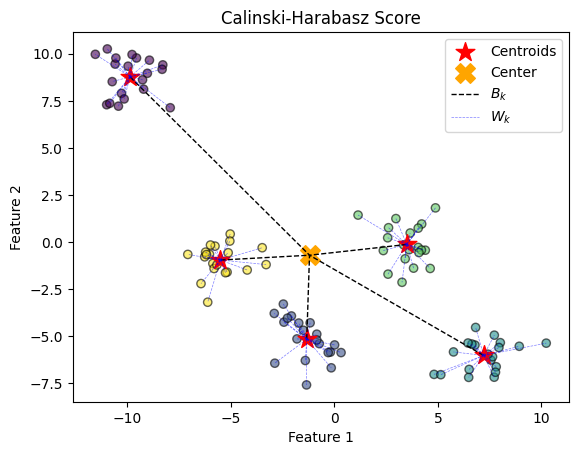

In [10]:
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap="viridis", alpha=0.6, edgecolors="k")
plt.scatter(centroids[:, 0], centroids[:, 1], c="red", marker='*', s=200, label="Centroids")

center_x = X[:, 0].mean()
center_y = X[:, 1].mean()

plt.scatter(center_x, center_y, c="orange", marker="X", s=200, label="Center")

for i, centroid in enumerate(centroids):
    if i == 0:
        plt.plot([centroid[0], center_x], [centroid[1], center_y], 'k--', linewidth=1, label="$B_k$")
    else:
        plt.plot([centroid[0], center_x], [centroid[1], center_y], 'k--', linewidth=1)

blue_line_drawn = False
for i, centroid in enumerate(centroids):
    cluster_points = X[kmeans.labels_ == i]  # Get all points in cluster i
    for point in cluster_points:
        if not blue_line_drawn:
            plt.plot([centroid[0], point[0]], [centroid[1], point[1]], 'b--', linewidth=0.5, alpha=0.5, label="$W_k$")
            blue_line_drawn = True
        else:
            plt.plot([centroid[0], point[0]], [centroid[1], point[1]], 'b--', linewidth=0.5, alpha=0.5)

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.title("Calinski-Harabasz Score")
plt.show()

#### (3) Silhouette Coefficient
* nearest cluster is identified as the cluster with the minimum average distance to the data point compared to all other clusters except the one it belongs to
* ranges from (-1, 1), the larger the better

$$
S_i = \frac{Dmin^{out}_i − Davg^{in}_i}{\max\{{Dmin^{out}_i}, Davg^{in}_i\}}.
$$

In [11]:
help(silhouette_score)

Help on function silhouette_score in module sklearn.metrics.cluster._unsupervised:

silhouette_score(X, labels, *, metric='euclidean', sample_size=None, random_state=None, **kwds)
    Compute the mean Silhouette Coefficient of all samples.
    
    The Silhouette Coefficient is calculated using the mean intra-cluster
    distance (``a``) and the mean nearest-cluster distance (``b``) for each
    sample.  The Silhouette Coefficient for a sample is ``(b - a) / max(a,
    b)``.  To clarify, ``b`` is the distance between a sample and the nearest
    cluster that the sample is not a part of.
    Note that Silhouette Coefficient is only defined if number of labels
    is ``2 <= n_labels <= n_samples - 1``.
    
    This function returns the mean Silhouette Coefficient over all samples.
    To obtain the values for each sample, use :func:`silhouette_samples`.
    
    The best value is 1 and the worst value is -1. Values near 0 indicate
    overlapping clusters. Negative values generally indi

In [12]:
s_score = silhouette_score(X, y_pred)
s_samples = silhouette_samples(X, y_pred)

print(f"Silhouette Score is: {s_score:.2f}")
print(f"Average Silhouette Samples is: {np.mean(s_samples):.2f}")

Silhouette Score is: 0.74
Average Silhouette Samples is: 0.74


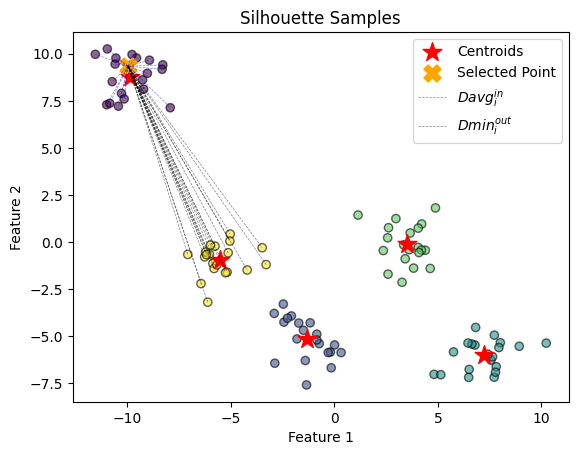

In [13]:
labels = kmeans.labels_
cluster_labels = np.unique(labels)
selected_cluster = np.random.choice(cluster_labels)

selected_cluster_points = X[labels == selected_cluster]
selected_point = selected_cluster_points[np.random.randint(len(selected_cluster_points))]

avg_distances = []
for cluster in cluster_labels:
    if cluster != selected_cluster:  # Exclude the selected point's own cluster
        cluster_points = X[labels == cluster]  # Get all points in the other cluster
        avg_distance = np.mean(pairwise_distances([selected_point], cluster_points))  # Compute average distance
        avg_distances.append((cluster, avg_distance))

closest_cluster_label = min(avg_distances, key=lambda x: x[1])[0]
closest_cluster_points = X[labels == closest_cluster_label]  # Get all points from closest cluster
closest_centroid = centroids[closest_cluster_label]

plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap="viridis", alpha=0.6, edgecolors="k")
plt.scatter(centroids[:, 0], centroids[:, 1], c="red", marker='*', s=200, label="Centroids")
plt.scatter(selected_point[0], selected_point[1], c="orange", marker="X", s=150, label="Selected Point")

for i, point in enumerate(selected_cluster_points):
    if i==0:
        plt.plot([selected_point[0], point[0]], [selected_point[1], point[1]], 'b--', linewidth=0.5, alpha=0.5, label="$Davg^{in}_i$")
    else:
        plt.plot([selected_point[0], point[0]], [selected_point[1], point[1]], 'b--', linewidth=0.5, alpha=0.5)

for i, point in enumerate(closest_cluster_points):
    if i==0:
        plt.plot([selected_point[0], point[0]], [selected_point[1], point[1]], 'k--', linewidth=0.5, alpha=0.5, label="$Dmin^{out}_i$")
    else:
        plt.plot([selected_point[0], point[0]], [selected_point[1], point[1]], 'k--', linewidth=0.5, alpha=0.5)


plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.title("Silhouette Samples")
plt.show()

In [14]:
X_str = list(map(str, X))
silhouette_df = pd.DataFrame({"X_points": X_str, "silhouette_samples": s_samples})
silhouette_df

,X_points,silhouette_samples
0,[-10.42528517 7.21462004],0.786105
1,[-9.02841836 8.96131039],0.852029
2,[-10.27760104 7.8945867 ],0.838487
3,[-5.8674424 -1.14745303],0.811705
4,[-11.54095018 9.97070307],0.808142
...,...,...
95,[ 2.36272731 -0.46092973],0.712088
96,[-8.31602459 9.17316643],0.809217
97,[-9.76781542 9.95958162],0.854063
98,[-9.9591988 9.33956772],0.871443


In [15]:
np.mean(silhouette_df["silhouette_samples"])

np.float64(0.7383419843974767)

#### (4) Davies-Bouldin Index
* the average similarity measure of each cluster with its most similar cluster
* similarity is the ratio of within-cluster distances to between-cluster distances
* minimum score is 0, the smaller the better

$$
R_{ij} = \frac{s_i +s_j}{d_{ij}},
$$

In [16]:
help(davies_bouldin_score)

Help on function davies_bouldin_score in module sklearn.metrics.cluster._unsupervised:

davies_bouldin_score(X, labels)
    Compute the Davies-Bouldin score.
    
    The score is defined as the average similarity measure of each cluster with
    its most similar cluster, where similarity is the ratio of within-cluster
    distances to between-cluster distances. Thus, clusters which are farther
    apart and less dispersed will result in a better score.
    
    The minimum score is zero, with lower values indicating better clustering.
    
    Read more in the :ref:`User Guide <davies-bouldin_index>`.
    
    .. versionadded:: 0.20
    
    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        A list of ``n_features``-dimensional data points. Each row corresponds
        to a single data point.
    
    labels : array-like of shape (n_samples,)
        Predicted labels for each sample.
    
    Returns
    -------
    score: float
        The resulting

In [17]:
db_score = davies_bouldin_score(X, y_pred)

print(f"Davies-Bouldin Score is: {db_score:.2f}")

Davies-Bouldin Score is: 0.35


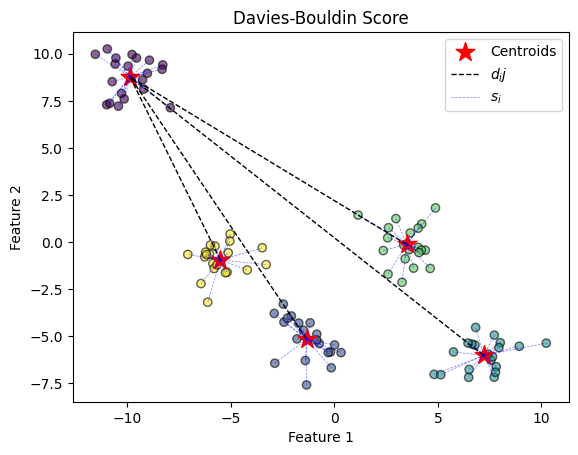

In [18]:
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap="viridis", alpha=0.6, edgecolors="k")
plt.scatter(centroids[:, 0], centroids[:, 1], c="red", marker='*', s=200, label="Centroids")

center_x = X[:, 0].mean()
center_y = X[:, 1].mean()

for i, centroid in enumerate(centroids):
    if i == 0:
        plt.plot([centroid[0], centroids[selected_cluster][0]], [centroid[1], centroids[selected_cluster][1]], 'k--', linewidth=1, label="$d_ij$")
    else:
        plt.plot([centroid[0], centroids[selected_cluster][0]], [centroid[1], centroids[selected_cluster][1]], 'k--', linewidth=1)

blue_line_drawn = False
for i, centroid in enumerate(centroids):
    cluster_points = X[kmeans.labels_ == i]  # Get all points in cluster i
    for point in cluster_points:
        if not blue_line_drawn:
            plt.plot([centroid[0], point[0]], [centroid[1], point[1]], 'b--', linewidth=0.5, alpha=0.5, label="$s_i$")
            blue_line_drawn = True
        else:
            plt.plot([centroid[0], point[0]], [centroid[1], point[1]], 'b--', linewidth=0.5, alpha=0.5)

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.title("Davies-Bouldin Score")
plt.show()

#### (5) Gap Statistic
* compares the observed within-cluster sum-of-squared distances with a reference null distribution generated using a MC method approach (reference clusterings are created from $b$ realizations of data)

In [19]:
def gen_realizations(X, b, random_state=None):
    """Generate b random realizations of X

    The realizations are drawn from a uniform distribution over the range of
    observed values for that feature.

    Parameters
    ---------
    X : array
        Design matrix with each row corresponding to a point
    b : int
        Number of realizations for the reference distribution
    random_state : int, default=None
        Determines random number generation for realizations

    Returns
    -------
    X_realizations : array
        random realizations with shape (b, X.shape[0], X.shape[1])
    """
    mins = X.min(axis=0)
    maxs = X.max(axis=0)
    rng = np.random.default_rng(random_state)
    nrows, ncols = X.shape
    return rng.uniform(
        np.tile(mins, (b, nrows, 1)),
        np.tile(maxs, (b, nrows, 1)),
        size=(b, nrows, ncols),
    )

In [20]:
def gap_statistic(X, y, centroids, dist, b, clusterer, random_state=None):
    X_refs = gen_realizations(X, b, random_state)

    Wk_original = pooled_within_ssd(X, y, centroids, dist)

    Wk_random = np.zeros(b)
    for i in range(b):
        clusterer.fit(X_refs[i])
        centroids_random = clusterer.cluster_centers_
        random_labels = clusterer.labels_
        Wk_random[i] = pooled_within_ssd(X_refs[i], random_labels, centroids_random, dist)
        
    log_Wk_original = np.log(Wk_original)
    log_Wk_random_mean = np.mean(np.log(Wk_random))
    gs = log_Wk_random_mean - log_Wk_original
    
    gs_std = np.std(np.log(Wk_random)) 
    return gs, gs_std, X_refs

In [21]:
gs, gs_std, X_refs = gap_statistic(X, y, centroids, dist, b=5, clusterer=KMeans(n_clusters=5, random_state=random_state, n_init="auto"))


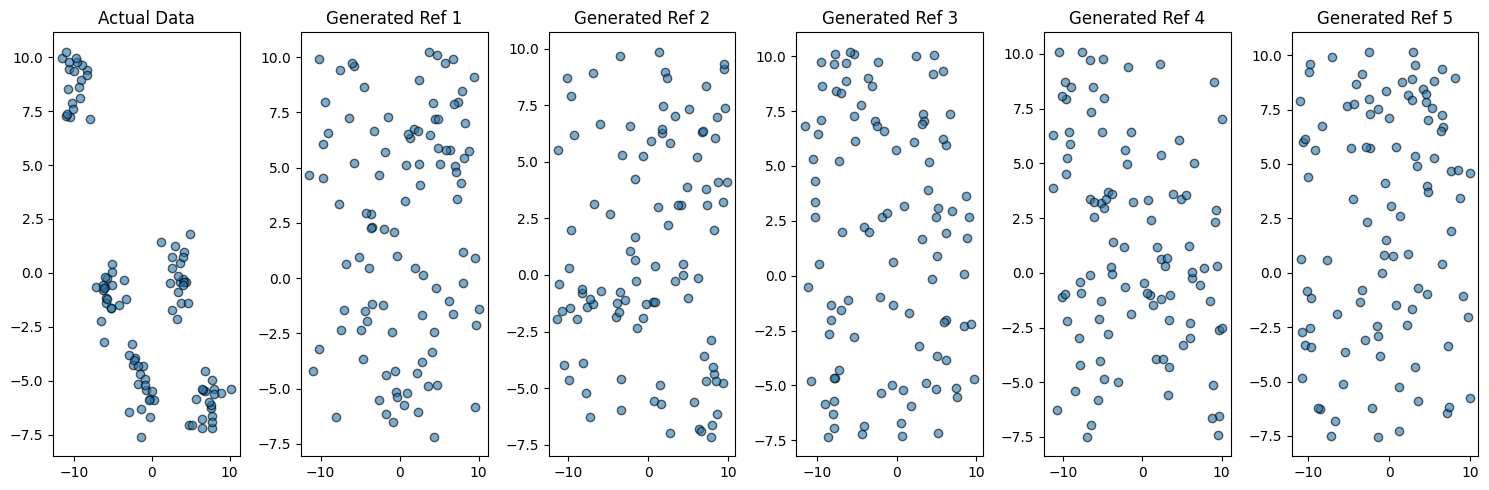

In [22]:
b=5

fig, axes = plt.subplots(1, b+1, figsize=(15, 5))

axes[0].scatter(X[:, 0], X[:, 1], alpha=0.6, edgecolors="k")
axes[0].set_title("Actual Data")

for i in range(b):
    axes[i+1].scatter(X_refs[i][:, 0], X_refs[i][:, 1], alpha=0.6, edgecolors="k")
    axes[i+1].set_title(f"Generated Ref {i+1}")

plt.tight_layout()
plt.show()

### External Validation Criteria

#### (1) Cluster Purity

#### (2) Adjusted Mutual Information

#### (3) Adjusted Rand Index

## Selecting $k$
Parameter tuning with internal measures
* Internal measures may show an inflection point (or "elbow") at the correct choice of parameter
* For k-means clustering, the sum of squares measure will always reduce with the number of clusters, but it will reduce at a sharply lower rate after the inflection point
* For a measure such as the ratio of intra-cluster to inter-cluster distance, the measure will reduce until the inflection point and then may increase slightly
* Plots can be used in conjunction with visual inspection of the scatter plot of the data and the algorithm partitioning to determine the correct number of clusters in many cases
* Such tuning techniques with internal measures should be used as an informal rule of thumb, rather than as a strict criterion

*One desirable property of grid-based and density-based algorithms is that the number of data clusters is not pre-defined in advance, as in k-means algorithms*

## Hierarchical Clustering
* organize data into a hierarchy of clusters, build a tree-like structure
* you "cut" (cluster) the data after analysis

### Divisive Clustering
* top-down approach where clusters are successively partitioned into smaller clusters

### Agglomerative Clustering
* bottom-up approach where smaller clusters are merged with nearby clusters
* not as computationally efficient as divisive clustering, but better for interpretation
</br></br>

**Key Steps**
1. Define a distance metric; Assign each data point to its own cluster
2. Merge two closest clusters using distance metric
3. Delete entry for those two closest clusters and create new entry for the merged cluster
4. Repeat until termination criterion (no. of clusters = 1)
</br></br>

**Notes on How to Read a Dendogram**
* leaves represent data points
* branches show cluster merges
* height represents distance or dissimilarity
* cuting the dendogram -> no. of clusters
    * the number of lines that are intersected by the horizontal cut represents the no. of clusters
* if you cut the dendrogram at a height where there is a large jump in the distance between merges, it often indicates a natural grouping in the data
    * large vertical distances suggests very dissimilar clusters being merged
</br></br>

**Z (linkage matrix)**
* full record of merging steps
* each row represents a merge between two clusters
* contains:
    * first two elements are the two clusters merged at each step
    * distance between these clusters
    * size of the new cluster

#### (1) Single Linkage
* smallest distance between a point from one cluster to any point in the other cluster
* minimum distance between all pairs of objects
* effective for discovering clusters of arbitrary shapes
* can merge clusters successively through chains of data point pairs at small pairwise distances
* sensitive to noise

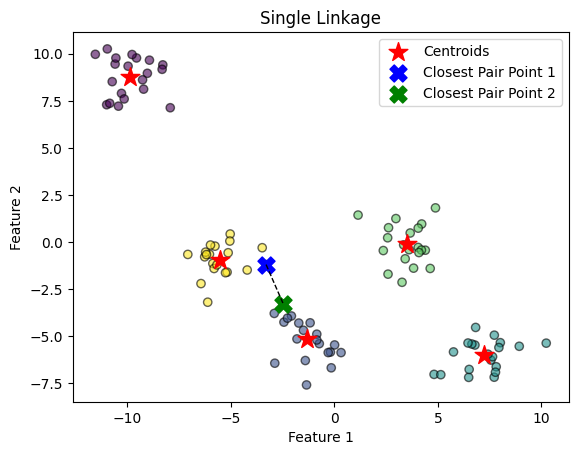

In [ ]:
selected_cluster = np.random.choice(cluster_labels)
selected_cluster_points = X[labels == selected_cluster]

selected_point = selected_cluster_points[np.random.randint(len(selected_cluster_points))]

distances_within_cluster = pairwise_distances([selected_point], selected_cluster_points)[0]
farthest_point = selected_cluster_points[np.argmax(distances_within_cluster)]

avg_distances = []
for cluster in cluster_labels:
    if cluster != selected_cluster:
        cluster_points = X[labels == cluster]
        avg_distance = np.mean(pairwise_distances([selected_point], cluster_points))
        avg_distances.append((cluster, avg_distance))

closest_cluster_label = min(avg_distances, key=lambda x: x[1])[0]
closest_cluster_points = X[labels == closest_cluster_label]

distances_between_clusters = pairwise_distances(selected_cluster_points, closest_cluster_points)
min_dist_indices = np.unravel_index(np.argmin(distances_between_clusters), distances_between_clusters.shape)
closest_pair_point_1 = selected_cluster_points[min_dist_indices[0]]
closest_pair_point_2 = closest_cluster_points[min_dist_indices[1]]

plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="viridis", alpha=0.6, edgecolors="k")
plt.scatter(centroids[:, 0], centroids[:, 1], c="red", marker='*', s=200, label="Centroids")
plt.scatter(closest_pair_point_1[0], closest_pair_point_1[1], c="blue", marker="X", s=150, label="Closest Pair Point 1")
plt.scatter(closest_pair_point_2[0], closest_pair_point_2[1], c="green", marker="X", s=150, label="Closest Pair Point 2")

plt.plot([closest_pair_point_1[0], closest_pair_point_2[0]], [closest_pair_point_1[1], closest_pair_point_2[1]], 'k--', linewidth=1)

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.title("Single Linkage")
plt.show()

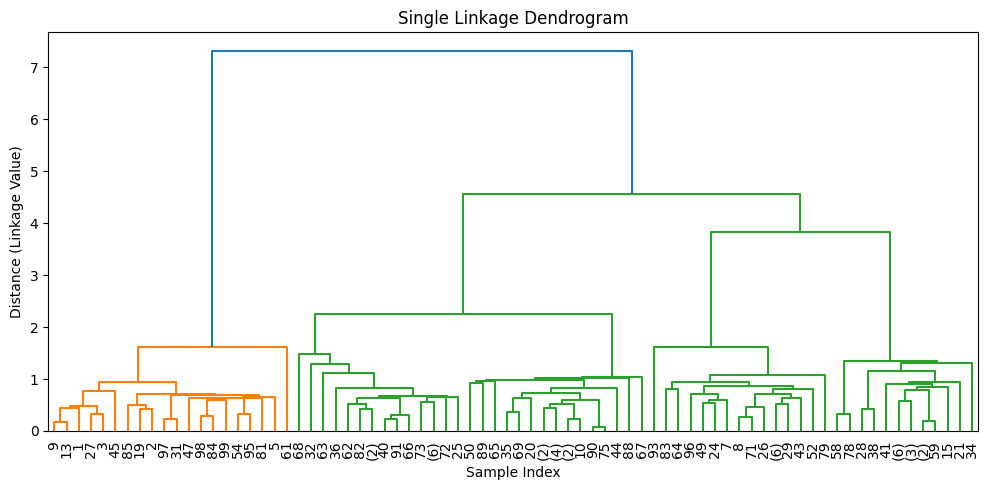

In [ ]:
Z = linkage(X, method="single", optimal_ordering=True)

plt.figure(figsize=(10, 5))
dendrogram(
    Z,
    truncate_mode="level",
    p=10,
    labels=np.arange(1, X.shape[0] + 1), 
    leaf_rotation=90,                    
    leaf_font_size=10,                   
)
plt.title("Single Linkage Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance (Linkage Value)")
plt.tight_layout()
plt.show()

In [149]:
Z[0]

array([7.40000000e+01, 8.90000000e+01, 8.29232092e-02, 2.00000000e+00])

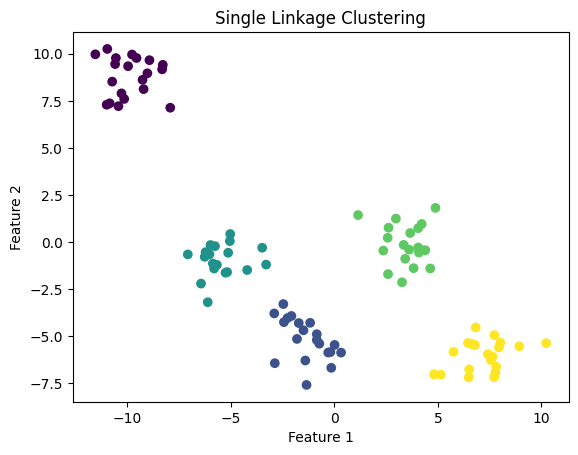

In [39]:
y_predict = fcluster(Z, t=2, criterion="distance")
plt.scatter(X[:, 0], X[:, 1], c=y_predict)

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Single Linkage Clustering")
plt.show()

#### (2) Complete Linkage
* farthest distance between a point from one cluster to any point in the other cluster
* maximum distance between all pairs of objects
* attempts to minimize the maximum diameter of a cluster
* breaks up larger clusters and biased towards creating spherical clusters
* gives too much importance to data points at the edge of a cluster

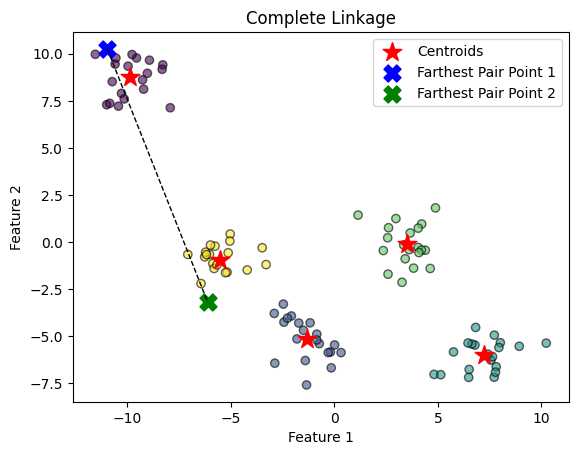

In [52]:
selected_cluster = np.random.choice(cluster_labels)
selected_cluster_points = X[labels == selected_cluster]

selected_point = selected_cluster_points[np.random.randint(len(selected_cluster_points))]

distances_within_cluster = pairwise_distances([selected_point], selected_cluster_points)[0]
farthest_point = selected_cluster_points[np.argmax(distances_within_cluster)]

avg_distances = []
for cluster in cluster_labels:
    if cluster != selected_cluster:
        cluster_points = X[labels == cluster]
        avg_distance = np.mean(pairwise_distances([selected_point], cluster_points))
        avg_distances.append((cluster, avg_distance))

closest_cluster_label = min(avg_distances, key=lambda x: x[1])[0]
closest_cluster_points = X[labels == closest_cluster_label]

distances_between_clusters = pairwise_distances(selected_cluster_points, closest_cluster_points)
min_dist_indices = np.unravel_index(np.argmax(distances_between_clusters), distances_between_clusters.shape)
closest_pair_point_1 = selected_cluster_points[min_dist_indices[0]]
closest_pair_point_2 = closest_cluster_points[min_dist_indices[1]]

plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="viridis", alpha=0.6, edgecolors="k")
plt.scatter(centroids[:, 0], centroids[:, 1], c="red", marker='*', s=200, label="Centroids")
plt.scatter(closest_pair_point_1[0], closest_pair_point_1[1], c="blue", marker="X", s=150, label="Farthest Pair Point 1")
plt.scatter(closest_pair_point_2[0], closest_pair_point_2[1], c="green", marker="X", s=150, label="Farthest Pair Point 2")

plt.plot([closest_pair_point_1[0], closest_pair_point_2[0]], [closest_pair_point_1[1], closest_pair_point_2[1]], 'k--', linewidth=1)

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.title("Complete Linkage")
plt.show()

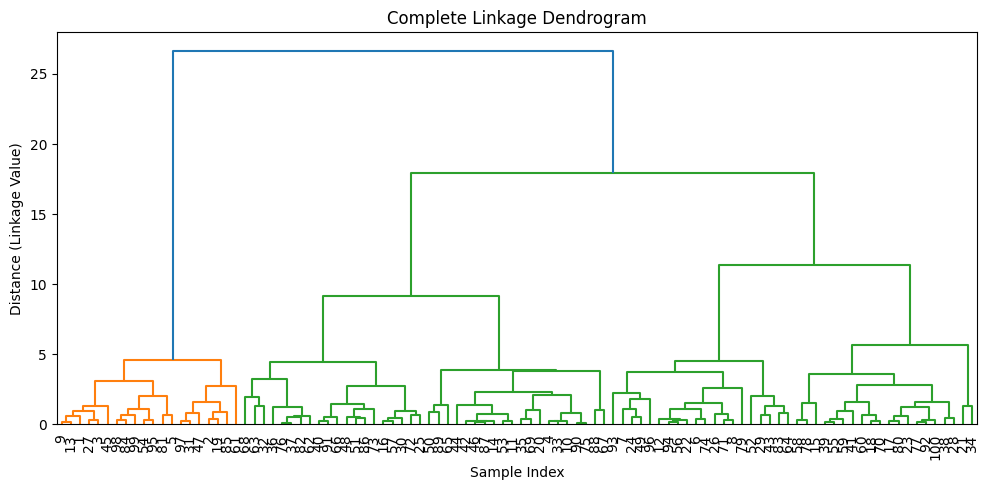

In [53]:
Z = linkage(X, method="complete", optimal_ordering=True)

plt.figure(figsize=(10, 5))
dendrogram(
    Z,
    truncate_mode="level",
    p=10,
    labels=np.arange(1, X.shape[0] + 1), 
    leaf_rotation=90,                    
    leaf_font_size=10,                   
)
plt.title("Complete Linkage Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance (Linkage Value)")
plt.tight_layout()
plt.show()

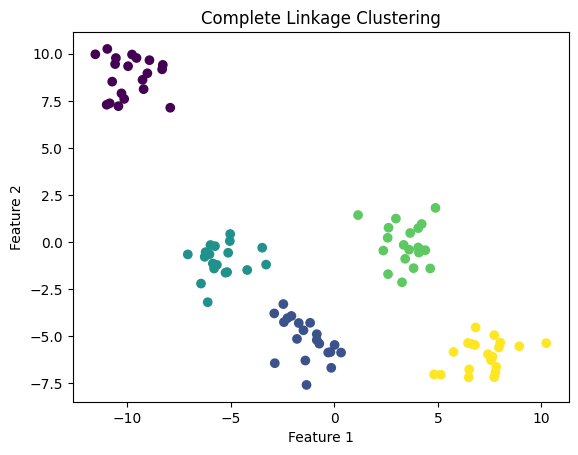

In [54]:
y_predict = fcluster(Z, t=7, criterion="distance")
plt.scatter(X[:, 0], X[:, 1], c=y_predict)

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Complete Linkage Clustering")
plt.show()

#### (3) Average Linkage
* uses the average intercluster distance as the metric
* average distance between all pairs of objects

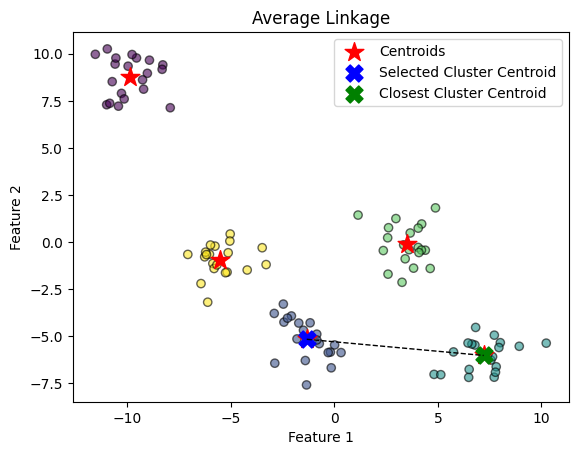

In [55]:
selected_cluster = np.random.choice(cluster_labels)
selected_cluster_points = X[labels == selected_cluster]

selected_point = selected_cluster_points[np.random.randint(len(selected_cluster_points))]

distances_within_cluster = pairwise_distances([selected_point], selected_cluster_points)[0]
farthest_point = selected_cluster_points[np.argmax(distances_within_cluster)]

avg_distances = []
for cluster in cluster_labels:
    if cluster != selected_cluster:
        cluster_points = X[labels == cluster]
        avg_distance = np.mean(pairwise_distances([selected_point], cluster_points))
        avg_distances.append((cluster, avg_distance))

closest_cluster_label = min(avg_distances, key=lambda x: x[1])[0]
closest_cluster_centroid = centroids[closest_cluster_label]
selected_cluster_centroid = centroids[selected_cluster]

plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="viridis", alpha=0.6, edgecolors="k")
plt.scatter(centroids[:, 0], centroids[:, 1], c="red", marker='*', s=200, label="Centroids")
plt.scatter(selected_cluster_centroid[0], selected_cluster_centroid[1], c="blue", marker="X", s=150, label="Selected Cluster Centroid")
plt.scatter(closest_cluster_centroid[0], closest_cluster_centroid[1], c="green", marker="X", s=150, label="Closest Cluster Centroid")

plt.plot([selected_cluster_centroid[0], closest_cluster_centroid[0]], [selected_cluster_centroid[1], closest_cluster_centroid[1]], 'k--', linewidth=1)

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.title("Average Linkage")
plt.show()

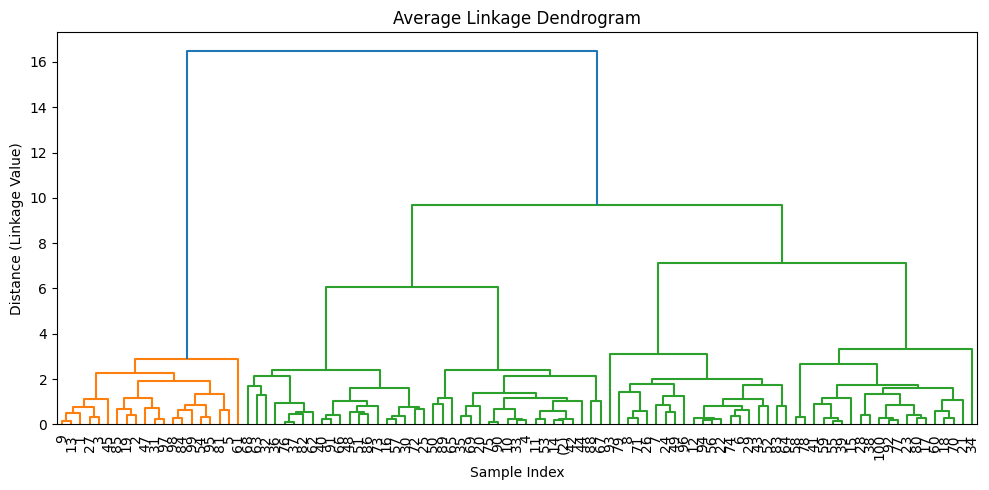

In [60]:
Z = linkage(X, method="average", optimal_ordering=True)

plt.figure(figsize=(10, 5))
dendrogram(
    Z,
    truncate_mode="level",
    p=10,
    labels=np.arange(1, X.shape[0] + 1), 
    leaf_rotation=90,                    
    leaf_font_size=10,                   
)
plt.title("Average Linkage Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance (Linkage Value)")
plt.tight_layout()
plt.show()

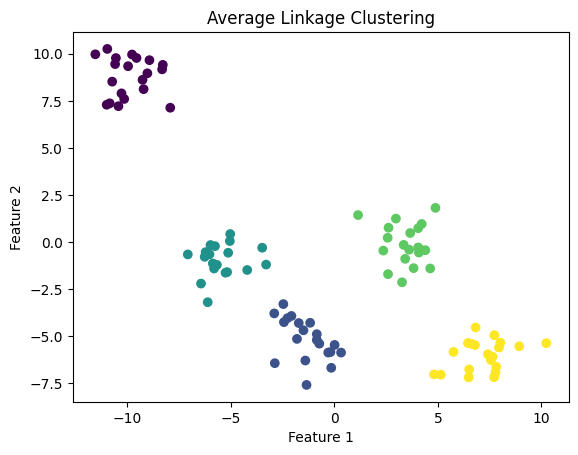

In [58]:
y_predict = fcluster(Z, t=4, criterion="distance")
plt.scatter(X[:, 0], X[:, 1], c=y_predict)

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Average Linkage Clustering")
plt.show()

#### (4) Ward's Method
* uses the change in the sum of squared errors as the merging criterion
* merge smaller ones first
* distance increases as we merge clusters

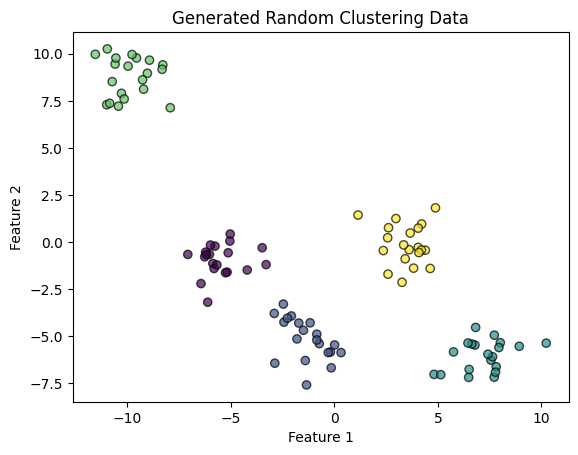

In [64]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.7, edgecolors='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Generated Random Clustering Data")
plt.show()

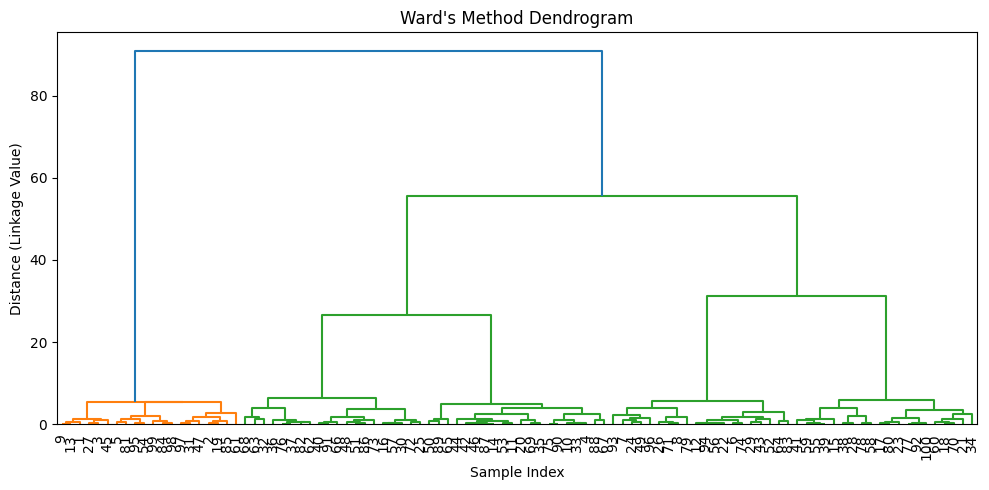

In [61]:
Z = linkage(X, method="ward", optimal_ordering=True)

plt.figure(figsize=(10, 5))
dendrogram(
    Z,
    truncate_mode="level",
    p=10,
    labels=np.arange(1, X.shape[0] + 1), 
    leaf_rotation=90,                    
    leaf_font_size=10,                   
)
plt.title("Ward's Method Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance (Linkage Value)")
plt.tight_layout()
plt.show()

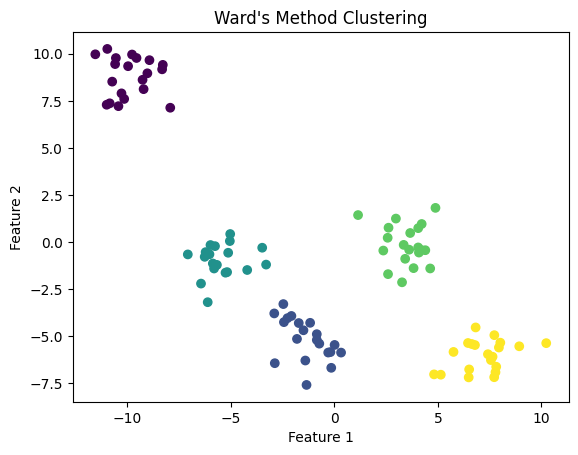

In [63]:
y_predict = fcluster(Z, t=20, criterion="distance")
plt.scatter(X[:, 0], X[:, 1], c=y_predict)

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Ward's Method Clustering")
plt.show()

## Density-Based Clustering
* instead of distance, uses density for determining clusters
* good for arbitrary shapes because they don't assume geometric structures
* noise points are not forced into a cluster
* continue growing a given cluster as long as the density (number of objects or data points) in the "neighborhood" meets some threshold
* good for a dataset that has notion of distance, usually not normalized (distance values can get distorted)

Guiding questions:
* How to measure density? -> define the neighborhood
* How would you say a point is in a less dense region? -> define the threshold

#### (1) DBSCAN
* randomly pick a core point and assign to first cluster
* core points within the radius of the first cluster are then added and on and on
    * first pass: core points only
* add non-core (border) points to the cluster after all core points have been added BUT don't extend anymore
    * non-core points can only join a cluster but not extend it further
    * if a non-core point is close to two clusters, we add it to first cluster (sequential implementation)

**Components:**
* *Core Point* if it meets the threshold of your defined neighborhood
* *Non-Core Point* if it doesn't meet the threshold of your defined neighborhood but has core point as neighbor
* *Noise Point* if it doesn't meet the threshold at all and no core point neighbor

*Usually min_points = 2x no. of dimensions*

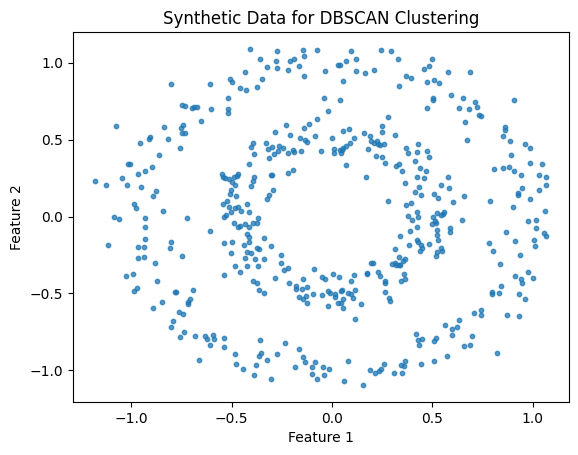

In [110]:
n_samples = 1500

X_circles, y_circles = make_circles(n_samples=n_samples // 3, factor=0.5, noise=0.08)

# plt.figure(figsize=(8, 6))
plt.scatter(X_circles[:, 0], X_circles[:, 1], s=10, alpha=0.75)
plt.title("Synthetic Data for DBSCAN Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [111]:
def get_kdist(k, data):
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(data)
    distances, _ = nbrs.kneighbors(data)
    sorted_kth_distances = np.sort(distances[:, k])[::-1]
    
    return list(sorted_kth_distances)

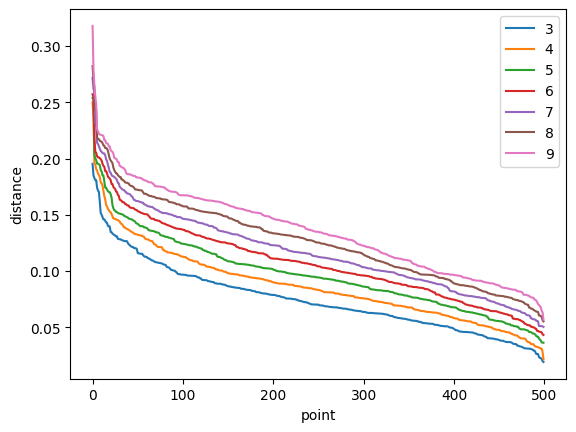

In [112]:
max = 10
for i in range(3, max):
    plt.plot(get_kdist(i, X_circles))
    plt.xlabel("point")
    plt.ylabel("distance")
    plt.legend(range(3, max))

In [113]:
len(X_circles)

500

In [114]:
len(y_circles)

500

Number of clusters: 2
Number of noise points: 3
Number of points in the largest cluster: 249
Number of points: 500


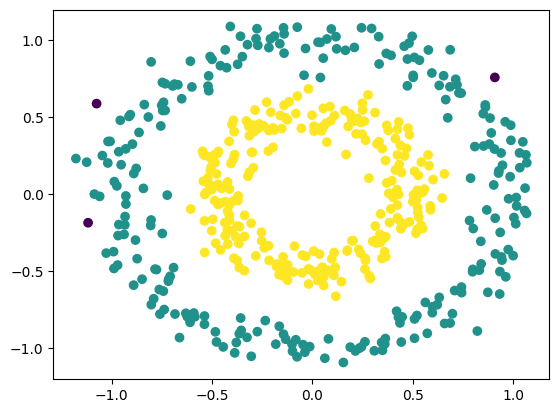

In [155]:
dbscan = DBSCAN(eps=0.15, min_samples=7)
cluster_labels = dbscan.fit_predict(X_circles)

# plt.figure(figsize=(10, 5))
print("Number of clusters:", cluster_labels.max() + 1)
print("Number of noise points:", (cluster_labels == -1).sum())
print(
    "Number of points in the largest cluster:",
    np.bincount(cluster_labels[cluster_labels >= 0]).max(),
)
print("Number of points:", len(cluster_labels))

plt.scatter(X_circles[:, 0], X_circles[:, 1], c=cluster_labels)
plt.show()

In [156]:
print(np.unique(cluster_labels))

[-1  0  1]


#### (2) OPTICS
* builds a reachability graph which assigns each sample both (1) a reachability distance and (2) a core distance -> determines cluster membership
    * core distance of a point is the minimum value of $\epsilon$ such that its $\epsilon$ neighborhood has at least minimum points        
        * minimum value to be a core point
        * if it is not a core point then it is undefined
    * reachability distance of point $p$ from $q$ is the minimum distance for $p$ to be directly density-reachable from $q$, which will only happen if $q$ is a core point
        * given by $\max(\text{core distance}(q), \text{distance}(p,q))$
        * if $q$ is not a core point then the reachability distance is undefined
</br></br>

**Key Concepts**
* Directly Density-Reachable
    * A point $p$ is directly density-reachable from a core point $q$ if $p$ is within the neighborhood of $q$, meaning $p$ is within a distance $\epsilon$ from $q$
    * Source point should be a core point
* (Indirectly) Density-Reachable
    * A point $p$ is (indirectly) density-reachable if there is a sequence of core points {$p_1$, $p_2$, ..., $p_n$}
        * $p_1$ is the starting core point
        * $p_n$ is the ending point
        * each successive point $p_{i+1}$ is directly density-reachable from $p_i$
* Density-Connected
    * Two points $p_1$ and $p_2$ are density-connected if both of them are density-reachable from a common core point $q$
    * Commutative -> if $p_1$ is density-connected to $p_2$, then $p_2$ is also density-connected to $p_1$
    * Each cluster in DBSCAN consists of density-connected points
</br></br>

**Step-by-Step**
1. Pick a starting point
2. Check density - if there are enough points, it becomes a core point
3. Expand the cluster - order the points by how reachable they are
4. Repeat for all points
5. Assess reachability plot
</br></br>

**Interpreting Reachability Plot**
* smaller $\epsilon$ = more clusters, larger $\epsilon$ = less clusters
* pick $\epsilon$ slightly above the lowest valley depths but below the peaks

Text(0, 0.5, 'reachability')

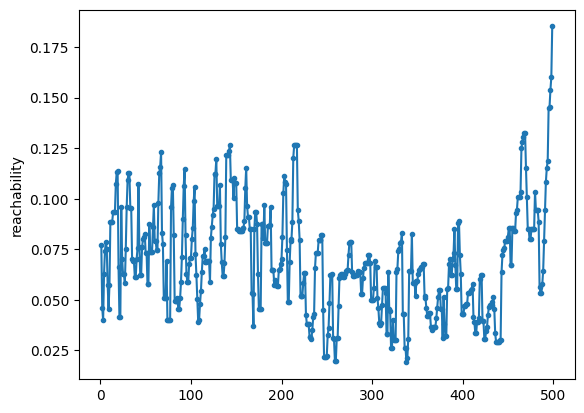

In [158]:
optics = OPTICS(min_samples=4, cluster_method="dbscan")
optics.fit(X_circles)

plt.plot(optics.reachability_[optics.ordering_], ".-")
plt.ylabel("reachability")

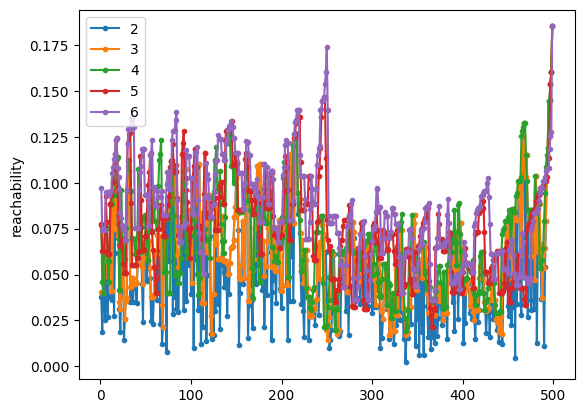

In [133]:
max = 7
for i in range(2, max):
    optics = OPTICS(min_samples=i, cluster_method="dbscan")
    optics.fit(X_circles)
    
    plt.plot(optics.reachability_[optics.ordering_], ".-")
    plt.ylabel("reachability")
    plt.legend(range(2, max))

Text(0, 0.5, 'reachability')

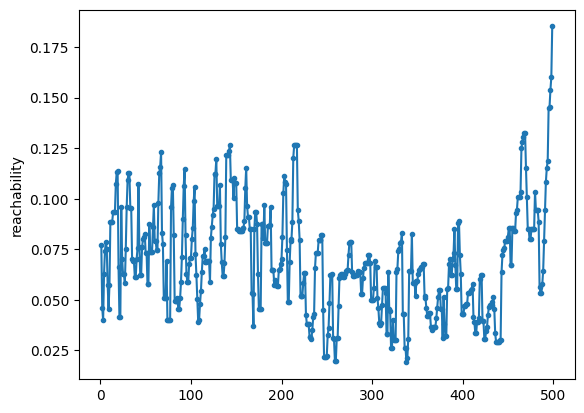

In [132]:
optics = OPTICS(min_samples=4, cluster_method="dbscan")
optics.fit(X_circles)

plt.plot(optics.reachability_[optics.ordering_], ".-")
plt.ylabel("reachability")

Number of clusters: 4
Number of noise points: 12
Number of points in the largest cluster: 248
Number of points: 500
Silhouette score: 0.11663734880283402


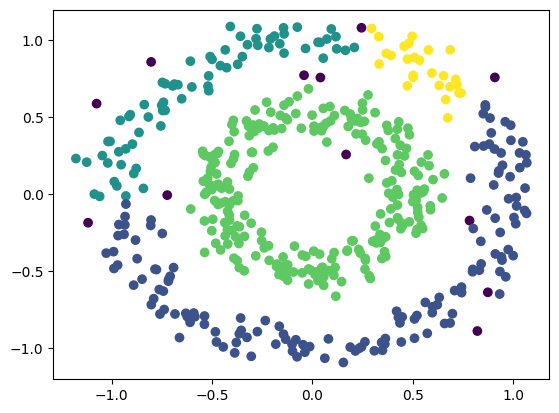

In [141]:
cluster_labels = cluster_optics_dbscan(
    reachability=optics.reachability_,
    core_distances=optics.core_distances_,
    ordering=optics.ordering_,
    eps=0.125,
)
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=cluster_labels)
print("Number of clusters:", cluster_labels.max() + 1)
print("Number of noise points:", (cluster_labels == -1).sum())
print(
    "Number of points in the largest cluster:",
    np.bincount(cluster_labels[cluster_labels >= 0]).max(),
)
print("Number of points:", len(cluster_labels))
print("Silhouette score:", silhouette_score(X_circles, cluster_labels))

Number of clusters: 9
Number of noise points: 142
Number of points in the largest cluster: 67
Number of points: 500
Silhouette score: 0.15570175498184946


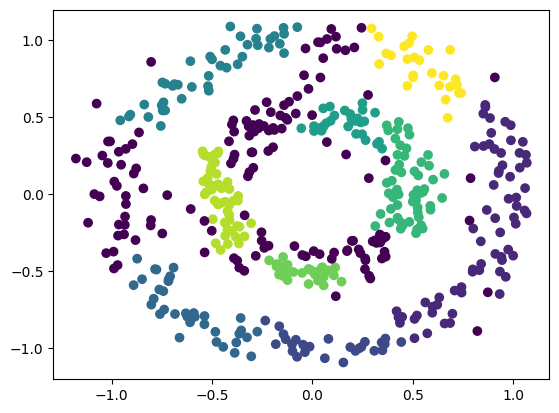

In [143]:
optics = OPTICS(
    min_samples=4, cluster_method="xi", xi=0.05, min_cluster_size=0.05
)
cluster_labels = optics.fit_predict(X_circles)
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=cluster_labels)
print("Number of clusters:", cluster_labels.max() + 1)
print("Number of noise points:", (cluster_labels == -1).sum())
print(
    "Number of points in the largest cluster:",
    np.bincount(cluster_labels[cluster_labels >= 0]).max(),
)
print("Number of points:", len(cluster_labels))
print("Silhouette score:", silhouette_score(X_circles, cluster_labels))


In [159]:
help(OPTICS)

Help on class OPTICS in module sklearn.cluster._optics:

class OPTICS(sklearn.base.ClusterMixin, sklearn.base.BaseEstimator)
 |  OPTICS(*, min_samples=5, max_eps=inf, metric='minkowski', p=2, metric_params=None, cluster_method='xi', eps=None, xi=0.05, predecessor_correction=True, min_cluster_size=None, algorithm='auto', leaf_size=30, memory=None, n_jobs=None)
 |  
 |  Estimate clustering structure from vector array.
 |  
 |  OPTICS (Ordering Points To Identify the Clustering Structure), closely
 |  related to DBSCAN, finds core sample of high density and expands clusters
 |  from them [1]_. Unlike DBSCAN, keeps cluster hierarchy for a variable
 |  neighborhood radius. Better suited for usage on large datasets than the
 |  current sklearn implementation of DBSCAN.
 |  
 |  Clusters are then extracted using a DBSCAN-like method
 |  (cluster_method = 'dbscan') or an automatic
 |  technique proposed in [1]_ (cluster_method = 'xi').
 |  
 |  This implementation deviates from the original OP